
**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2023**

---
# Trabajo práctico entregable - Parte 1

In [7]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pandasql as pdsql
from typing import List

sns.set_context("talk")

In [8]:
# Utils
# TODO: Create a module for these functions


def filter_extreme_rows(df: pd.DataFrame, column_list: List[str]):
    # Iterate over the columns and filter out the rows with extreme values
    for column in column_list:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df

## Lectura del data set

En la notebook 00 se explican los detalles de la siguiente sección.

In [9]:
url = "https://raw.githubusercontent.com/DiploDatos/AnalisisyVisualizacion/master/sysarmy_survey_2022_processed.csv"
df = pd.read_csv(url)

## Inspección general del data set

In [ ]:
# first, we visualize the first 5 rows and the corresponding columns
df.head()

In [ ]:
# then, we look at the number of rows and columns
df.shape

In [ ]:
# Let us now see the list of columns
df.columns

In [ ]:
# Let's check the data types of each column
df.dtypes

In [ ]:
# To finish this first inspection of the data, let's look at some
# basic statistics of the numerical columns of the DataFrame
df.describe()

---

# Ejercicio 1 - Análisis descriptivo

Responder a la pregunta: **¿Cuáles son los lenguajes de programación asociados a los mejores salarios?**

Para ello:
1. Seleccionar las columnas relevantes para analizar.
2. Seleccionar las filas relevantes para analizar. Esto incluye la eliminación de valores extremos y erróneos, pero también puede enfocar el análisis en una sub-población. Por ejemplo, se pueden limitar a personas con un salario mayor que 10000 pesos, o a las personas que trabajan sólo en "Data Science", pero deben justificar su elección y reformular la pregunta inicial de ser necesario.
  * Obtener una lista de los lenguajes de programación más populares. Decidir cuántos y cuáles seleccionan para incluir en el análisis.
  * Para cada una de las otras columnas del punto anterior, elegir los rangos o valores seleccionan para incluir en el análisis.
3. Seleccionar métricas que ayuden a responder la pregunta, y los métodos para analizarlas. Elegir UNA de las siguientes opciones:
  * Comparar las distribuciones de salario para cada lenguaje utilizando visualizaciones. Como la visualización es el producto final, debe ser clara y mostrar información relevante.
  * Comparar medidas de estadística descriptiva sobre la distribución de salario para cada lenguaje. Sean creativos, la estadística descriptiva nos permite decir cosas como: "el 10% de los mejores sueldos los ganan, en su mayoría, programadores que saben kotlin!" (donde *mayoría* es un término medio engañoso que sólo significa más del 50%). Para comparar múltiples lenguajes, les recomendamos usar también visualizaciones.
  * Comparar probabilidades. Por ejemplo: "Si sabés Python o Java, tenés un 30% más de chances de ganar arriba de 100K".

Si lo consideran necesario, realicen varias iteraciones. Es decir, si encuentran que las distribuciones de los lenguajes de programación que seleccionaron inicialmente no son muy diferentes, pueden re-hacer el análisis usando sólo los lenguajes de programación que son diferentes.

----------------------------

Para comparar cuáles son los lenguajes asociados a los mejores salarios, deberíamos primero definir un valor para cada lenguaje y luego hacer la comparación. En general, tendríamos que diseñar el test de hipótesis para poder comparar, pero en este caso creo que no se pretende hacer inferencia, sino simplemente describir para los datos de la base.

Idea Joaco: hacer boxplot.

Para obtener un valor a comparar, tendríamos que separar primero por lenguaje. Luego:
- ('work_contract_type') Remoto, Staff, etc., puede influir
- ('Trabajo de') va a influir, pero creería que está indisociablemente asociado al lenguaje
- ('profile_years_experience' & 'work_years_in_company') ¿separar los cuartiles del medio? Si no, decisión arbitraria del tipo 5 a 10 años, o comparar por cuartiles.
- ('work_work_modality') Quizás está relacionada a 'work_contract_type'.

Idea de reformulación de la pregunta a responder: ¿La presencia de qué lenguaje se asocia a los mayores salarios?

## Selección de columnas relevantes
Las columnas relevantes van a depender de cuál sea exactamente nuestra pregunta, pero podemos ir separando las que pueden estar relacionadas con lo que queremos ver, del resto de las columnas. Viendo la lista de columnas, las que a priori uno pensaría que pueden tener relación son:
- `'work_contract_type'`, e.g.: Remoto, Staff, etc.;
- `'Trabajo de'`, que pienso que va a influir, pero creería que está indisociablemente asociado al lenguaje (no podemos categorizar con esta columna);
- `'profile_years_experience'` y `'work_years_in_company'`, ¿separar los cuartiles del medio? Si no, decisión arbitraria del tipo 5 a 10 años, o comparar por cuartiles;
- `'work_work_modality'` quizás está relacionada a `'work_contract_type'`.


In [ ]:
df["work_contract_type"].unique()

In [ ]:
df["Trabajo de"].unique()

In [ ]:
df["profile_years_experience"].unique()

In [ ]:
df["work_years_in_company"].unique()

In [ ]:
df["work_work_modality"].unique()

In [ ]:
df["tools_programming_languages"].unique()
df.columns

2. Seleccionar las filas relevantes para analizar. Esto incluye la eliminación de valores extremos y erróneos, pero también puede enfocar el análisis en una sub-población. Por ejemplo, se pueden limitar a personas con un salario mayor que 10000 pesos, o a las personas que trabajan sólo en "Data Science", pero deben justificar su elección y reformular la pregunta inicial de ser necesario.

In [ ]:
df = filter_extreme_rows(df, ["salary_monthly_BRUTO", "salary_monthly_NETO"])
df = pdsql.sqldf(
    "SELECT * FROM df WHERE salary_monthly_BRUTO > 10000 AND salary_monthly_NETO > 10000 AND salary_monthly_BRUTO > salary_monthly_NETO"
)

---

### Armo el Dataframe por lenguaje

Notar que respuestas como `'CSS, HTML, Java, Javascript, SQL, TypeScript'` hay que parsearlas antes de poder hacer el conteo de frecuencias. Además, hay que limpiar los espacios en blanco y las diferencias en capitalización.


In [ ]:
# Initialize an empty dictionary to store the salary data for each language
language_salary_data = {}

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Convert the value in the 'tools_programming_languages' column to a string, then split it by comma
    languages = str(row["tools_programming_languages"]).lower().split(",")
    # Iterate over each programming language in the list
    for language in languages:
        # Clean the language string by removing leading/trailing spaces
        language = language.strip()
        # Check if the language is already in the dictionary
        if language in language_salary_data:
            # If it is, append the salary to the existing list of salaries for that language
            language_salary_data[language].append(row["salary_monthly_NETO"])
        else:
            # If it is not, create a new key-value pair in the dictionary for the language and its salary data
            language_salary_data[language] = [row["salary_monthly_NETO"]]

# Filter the language salary data dictionary to include only the languages that have more than twenty salary data point
language_salary_data_filtered = {
    language: salaries
    for language, salaries in language_salary_data.items()
    if len(salaries) > 20  # 20 because of reasons (?
}

# Initialize an empty list to store the statistics for each language
language_salary_stats = []

# Iterate over each language in the filtered dictionary
for language in language_salary_data_filtered:
    # Calculate the statistics for the salaries for that language
    salary_stats = [
        language,
        np.mean(language_salary_data_filtered[language]),
        np.median(language_salary_data_filtered[language]),
        np.std(language_salary_data_filtered[language]),
        len(language_salary_data_filtered[language]),
    ]
    # Append the statistics to the list of language statistics
    language_salary_stats.append(salary_stats)

# Create a DataFrame from the list of language statistics and name the columns
df_salary_stats = pd.DataFrame(
    language_salary_stats,
    columns=["Language", "Mean Salary", "Median Salary", "Standard Deviation", "Count"],
)

# Sort the DataFrame by frequency in descending order
df_salary_stats = df_salary_stats.sort_values(by="Count", ascending=False)

# Print the result
df_salary_stats

## To do
Do the boxplot or/and boxenplot for visualizing these previous data. In order to do this, I have to construct the dataframe that has `language` and `salary` columns, where each row represents a programmer. It is wired that I will have multiple columns for each programmer, but since we are looking at statistics for languages separately, I think it would be appropriate.

[Seaborn boxplot docs](https://seaborn.pydata.org/generated/seaborn.boxplot.html)

In [ ]:
# I sorted by count before to assess popularity, now I sort by mean salary to get closer to our question
df_salary_stats = df_salary_stats.sort_values(by="Mean Salary", ascending=False)
df_salary_stats

In [ ]:
# Style
sns.set_style("darkgrid")
plt.figure(figsize=(10, 9))

sns.barplot(
    data=df_salary_stats.query('Language != "ninguno de los anteriores"'),
    x="Mean Salary",
    y="Language",
    palette="magma",
)
plt.show()
# for the record, the following doesn't work
# errorbar=df_salary_stats['Standard Deviation']

I'm surprised bash is so up on the list. It would be interesting to see whether it is there cause the people that know a better paid language, like go or python, also happens to know bash. However, if there is a causal relation, I would be inclined to think that it is in fact contributing to be better paid.

### Ploteo un histograma de frecuencias
Esto es solamente para tener una visualización de las frecuencias y generar intuición sobre dónde hacer el corte.

In [ ]:
# Style
sns.set_style("darkgrid")

In [ ]:
# Create a DataFrame from the language_salary_data_filtered dictionary, with columns for language and count
df_language_count = pd.DataFrame(
    {
        "Language": list(language_salary_data_filtered.keys()),
        "Count": [
            len(language_salary_data_filtered[language])
            for language in language_salary_data_filtered
        ],
    }
)

# Sort the DataFrame by count in descending order
df_language_count = df_language_count.sort_values(by="Count", ascending=False)

# Initialize an empty list to store the relative frequency for each language
language_relative_frequency = []

# Iterate over each language in the sorted DataFrame
for language in df_language_count["Language"]:
    # Calculate the relative frequency for the language and append it to the list of relative frequencies
    frequency = len(language_salary_data_filtered[language]) / len(df)
    language_relative_frequency.append(frequency)

# Add the list of relative frequencies to the DataFrame
df_language_count["Relative Frequency"] = language_relative_frequency

# Create the histogram plot using Seaborn
sns.histplot(
    data=df_language_count[
        df_language_count["Language"] != "ninguno de los anteriores"
    ],
    x="Language",
    weights="Relative Frequency",
    binwidth=0.5,
)
plt.xticks(rotation=70)
plt.show()

# I'm filtering the 'ninguno de los anteriores' because of reasons (?

In [ ]:
# Maybe languages will look better on the vertical axis
# (because of the reading direction)

# we set the figure size
sns.set(rc={"figure.figsize": (10, 7)})  # (width, height)


# Create a DataFrame from the language_salary_data_filtered dictionary, with columns for language and count
df_language_count = pd.DataFrame(
    {
        "Language": list(language_salary_data_filtered.keys()),
        "Count": [
            len(language_salary_data_filtered[language])
            for language in language_salary_data_filtered
        ],
    }
)

# Sort the DataFrame by count in descending order
df_language_count = df_language_count.sort_values(by="Count", ascending=False)

# Initialize an empty list to store the relative frequency for each language
language_relative_frequency = []

# Iterate over each language in the sorted DataFrame
for language in df_language_count["Language"]:
    # Calculate the relative frequency for the language and append it to the list of relative frequencies
    frequency = len(language_salary_data_filtered[language]) / len(df)
    language_relative_frequency.append(frequency)

# Add the list of relative frequencies to the DataFrame
df_language_count["Relative Frequency"] = language_relative_frequency

# Create the histogram plot using Seaborn
sns.barplot(
    data=df_language_count[
        df_language_count["Language"] != "ninguno de los anteriores"
    ],
    x="Relative Frequency",
    y="Language",
)
plt.xticks(rotation=0)
plt.show()

# I'm filtering the 'ninguno de los anteriores' because of reasons (?

Idea de Lucas: ver la distribución de número de lenguajes por programador

In [ ]:
# Count the number of programming languages for each respondent
languages_per_programmer = (
    df["tools_programming_languages"]
    .fillna("")
    .str.split(",")
    .apply(lambda x: len([str(lang).strip() for lang in x]))
)

# Plot the distribution of the number of programming languages per programmer as a histogram
sns.histplot(
    languages_per_programmer, bins=range(1, 16), discrete=True, stat="probability"
)
plt.xticks(range(1, 16))
plt.xlabel("Number of programming languages")
plt.ylabel("Relative frequency")
plt.xlim(0.5, 15.5)
plt.show()

This looks roughly like a power law…

In [ ]:
# Compute the number of programming languages per programmer
df["languages_per_programmer"] = (
    df["tools_programming_languages"]
    .fillna("")
    .str.split(",")
    .apply(lambda x: len([str(lang).strip() for lang in x]))
)

# Filter out rows with 0 programming languages or more than 15 programming languages per programmer
df1 = df[(df["languages_per_programmer"] > 0) & (df["languages_per_programmer"] <= 15)]

# Group the data by the number of programming languages per programmer and compute the mean salary for each group
grouped = (
    df1.groupby("languages_per_programmer")["salary_monthly_NETO"].mean().reset_index()
)

# Plot a bar chart of the mean salary vs. the number of programming languages per programmer
plt.figure(figsize=(10, 6))
sns.barplot(
    x="languages_per_programmer", y="salary_monthly_NETO", data=grouped, palette="magma"
)
plt.xlabel("Number of Programming Languages per Programmer")
plt.ylabel("Mean Monthly Salary (NET)")
plt.title("Mean Monthly Salary vs. Number of Programming Languages per Programmer")
plt.show()

Uso `magma` porque el número de lenguajes es una variable secuencial (tiene orden) y este colormap es uno de los secuenciales que son perceptualmente uniformes.

En la [documentación](https://seaborn.pydata.org/generated/seaborn.barplot.html), indica un parámetro
> `errorbarstring`, (string, number) tuple, callable or None
Name of errorbar method (either “ci”, “pi”, “se”, or “sd”), or a tuple with a method name and a level parameter, or a function that maps from a vector to a (min, max) interval, or None to hide errorbar.

In [ ]:
# Define the data
languages_per_programmer = (
    df["tools_programming_languages"]
    .fillna("")
    .str.split(",")
    .apply(lambda x: len([str(lang).strip() for lang in x]))
)
salary = df["salary_monthly_NETO"]

# Combine the data into a new dataframe
data = pd.concat([languages_per_programmer, salary], axis=1)

# Filter out entries with more than 15 programming languages
data = data[data["tools_programming_languages"] <= 15]

# Calculate the mean salary and standard deviation for each number of programming languages
mean_salary = data.groupby("tools_programming_languages").mean().reset_index()
std_salary = data.groupby("tools_programming_languages").std().reset_index()

# Create the plot with error bars
sns.barplot(
    x="tools_programming_languages", y="salary_monthly_NETO", data=data, errorbar="sd"
)

# I'm setting the inferior limit to zero, since error bars get to negative values cause thery are taken symmetric
plt.ylim(0, 1000000)

# Set the axis labels and title
plt.xlabel("Number of programming languages")
plt.ylabel("Monthly net salary (ARS)")
plt.title("Salary vs number of programming languages")
plt.show()

Si esto está bien hecho, entonces las variaciones entre número de lenguajes de programación no son significativas a la hora de comparar salarios, mucho menos comparado con las variaciones (reflejadas arriba por las desviaciones estándar). Por esto, en lugar de pensar en el conjunto de lenguajes mejor pagos, podemos justificar hablar del lenguaje mejor pago, pensándolo como “el lenguaje cuya presencia en el conjunto de lenguajes que sabés, se relaciona a salarios más altos”.

Esto no quita que dentro de un número de lenguajes, los valores clustericen en altos y bajos salarios para ciertos conjuntos de lenguajes.

In [ ]:
# complete here if you want to include more columns
relevant_columns = ["tools_programming_languages", "salary_monthly_NETO"]

In [ ]:
# my version
relevant_columns = [
    "tools_programming_languages",
    "salary_monthly_NETO",
    "work_contract_type",
    "Trabajo de",
    "profile_years_experience",
    "work_years_in_company",
    "work_work_modality",
]

In [ ]:
df1 = df[relevant_columns]

In [ ]:
sns.pairplot(data=df1)
plt.show()

In [ ]:
columns_to_correlate = [
    "salary_monthly_NETO",
    "profile_years_experience",
    "work_years_in_company",
]
df_corr = df[columns_to_correlate].dropna().corr()
df_corr

In [ ]:
# heatmap to better visualize this
sns.heatmap(df_corr, annot=True)
plt.show()

### Conteo de frecuencias de los lenguajes de programación

La columna que contiene información sobre los lenguajes de programación utilizados es `tools_programming_languages`. Sus valores son strings con los lenguajes seleccionados separados por comas.



In [ ]:
df.tools_programming_languages[:3]

Las siguientes celdas de código separan estos lenguajes de programación y cuentan la frecuencia con la que aparecen.

No es necesario entender este código en profundidad, aunque sí es un buen ejercicio.

In [ ]:
# Convert the comma-separated string of languages to a list of string.
# Remove 'ninguno de los anteriores' option, spaces and training commas.
def split_languages(languages_str):
    if not isinstance(languages_str, str):
        return []
    # Remove 'other' option
    languages_str = languages_str.lower().replace("ninguno de los anteriores", "")
    # Split string into list of items
    # Remove spaces and commas for each item
    return [lang.strip().replace(",", "") for lang in languages_str.split()]


# Create a new column with the list of languages
df.loc[:, "cured_programming_languages"] = df.tools_programming_languages.apply(
    split_languages
)
if "cured_programming_languages" not in relevant_columns:
    relevant_columns.append("cured_programming_languages")

# Duplicate each row of df for each programming language
# mentioned in the response.
# We only include in df_lang the columns we are going to analyze later, so we
# don't duplicate innecesary information.
df_lang = (
    df.cured_programming_languages.apply(pd.Series)
    .stack()
    .reset_index(level=-1, drop=True)
    .to_frame()
    .join(df[relevant_columns])
    .rename(columns={0: "programming_language"})
)
# Horrible programming style! But a lot of data science code can be written with
# as concatenations of functions (pipelines), and there's no elegant way of
# doing that on Python.
df_lang[:5]

En la columna `programming_language` se encuentra cada lenguaje por separado. Notar que si una respuesta contenía 3 lenguajes, como `"HTML, Javascript, Python"`, la fila ha sido replicada 3 veces. Por ello, hay tres filas con índice 1.

In [ ]:
language_count = (
    df_lang.programming_language.value_counts()
    .reset_index()
    .rename(columns={"index": "language", "programming_language": "frequency"})
)
language_count[:10]

In [ ]:
df_lang_for_box_plot = df_lang.drop(
    columns=["cured_programming_languages"], inplace=False
)
query = """
SELECT df_lang_for_box_plot.programming_language, salary_monthly_NETO, language_count.frequency
FROM df_lang_for_box_plot
LEFT JOIN
(
  SELECT programming_language, COUNT(*) AS frequency
  FROM df_lang_for_box_plot
  GROUP BY programming_language
  HAVING frequency > 300
) AS language_count ON language_count.programming_language = df_lang_for_box_plot.programming_language
WHERE frequency IS NOT NULL
"""

df_lang_for_box_plot = pdsql.sqldf(query)
sns.boxplot(
    y=df_lang_for_box_plot["programming_language"],
    x=df_lang_for_box_plot["salary_monthly_NETO"],
)

## Filtrado de lenguajes relevantes

El siguiente código permite seleccionar sólo las filas donde el valor de la columna `programming_language` se encuentre en la lista `interesting_languages`.

In [ ]:
# Filter out languages that we want to exclude
# Complete here with your selected list.
interesting_languages = ["python", "go"]
filtered_df_lang = df_lang[df_lang.programming_language.isin(interesting_languages)]
filtered_df_lang[:5]

In [ ]:
python_languages = ["python"]
python_df_lang = df_lang[df_lang.programming_language.isin(python_languages)]

go_languages = ["go"]
go_df_lang = df_lang[df_lang.programming_language.isin(go_languages)]


# sns.histplot(data=filtered_df_lang, x='salary_monthly_NETO', hue='programming_language', stat='density')

sns.histplot(data=go_df_lang, x="salary_monthly_NETO", label="Go", stat="density")
sns.histplot(
    data=python_df_lang, x="salary_monthly_NETO", label="Python", stat="density"
)
plt.legend()
plt.show()

Claramente es la cola ancha de la distribución lo que le da la ventaja a Go.

# Ejercicio 2 - Densidades y varias variables

Responder a la pregunta general: **¿Que herramientas (prácticas y teóricas) són útiles para explorar la base, descubrir patrones, asociaciones?**

Para ello considere (igual al ejercicio Anterior):
1. Seleccionar las columnas relevantes para analizar.
2. Seleccionar las filas relevantes para analizar. Esto incluye la eliminación de valores extremos y erróneos, pero también puede enfocar el análisis en sub-poblaciones. 

## a) Densidad conjunta

Que herramientas visuales y modelos puede utilizar para estudiar la distribución y comportamiento de sus datos? 

Elija tres variables numéricas y 2 variables categóricas. Visualice la base según varias de las variables elegidas. Puede describir de alguna forma el comportamiento de sus datos? Que herramientas utilizaría? Describa




## b) Asociación

* Necesitamos decidir si sacar o no la columna de salario bruto. Para hacer la encuesta más simple.
¿Existe una correlación entre el salario bruto y el neto? Que abordaje y medidas usaría



## c) Densidad condicional 

Estudie la distribución del salario según el nivel de estudio.

Separe la población según el nivel de estudio (elija dos subpoblaciones numerosas) y grafique de manera comparativa ambos histogramas de la variable `'salary_monthly_NETO'`
¿Considera que ambas variables son independientes?
¿Qué analizaría al respecto?

Calcule medidas de centralización y dispersión para cada subpoblación






In [11]:
nivel_estudios=df["profile_studies_level"].unique()
print(nivel_estudios)
dic=['Secundario','Terciario','Universitario','Posgrado/Especialización','Mastria','Doctorado','Posdoctorado']

['Universitario' nan 'Terciario' 'Secundario' 'Posgrado/Especialización'
 'Maestría' 'Doctorado' 'Posdoctorado']


In [12]:
counts = df['profile_studies_level'].value_counts()
top_two = counts.head(2)
top_two

profile_studies_level
Universitario    1811
Terciario         430
Name: count, dtype: int64

In [13]:
Uni_o_Ter=((df['profile_studies_level']=='Universitario')|(df['profile_studies_level']=='Terciario'))
b=(((df['profile_studies_level']=='Universitario')|(df['profile_studies_level']=='Terciario')))&(df['profile_studies_level_state']=='Completo')

ter=df['profile_studies_level']=='Terciario'
univ=df['profile_studies_level']=='Universitario'
df_Uni_o_Ter=df.loc[Uni_o_Ter]
df_twonuevo=df.loc[b]
df_twou=df.loc[univ]
df_twot=df.loc[ter]

In [14]:
Uni_o_Ter=((df['profile_studies_level']=='Universitario')|(df['profile_studies_level']=='Terciario'))
df_Uni_o_Ter=df.loc[Uni_o_Ter]


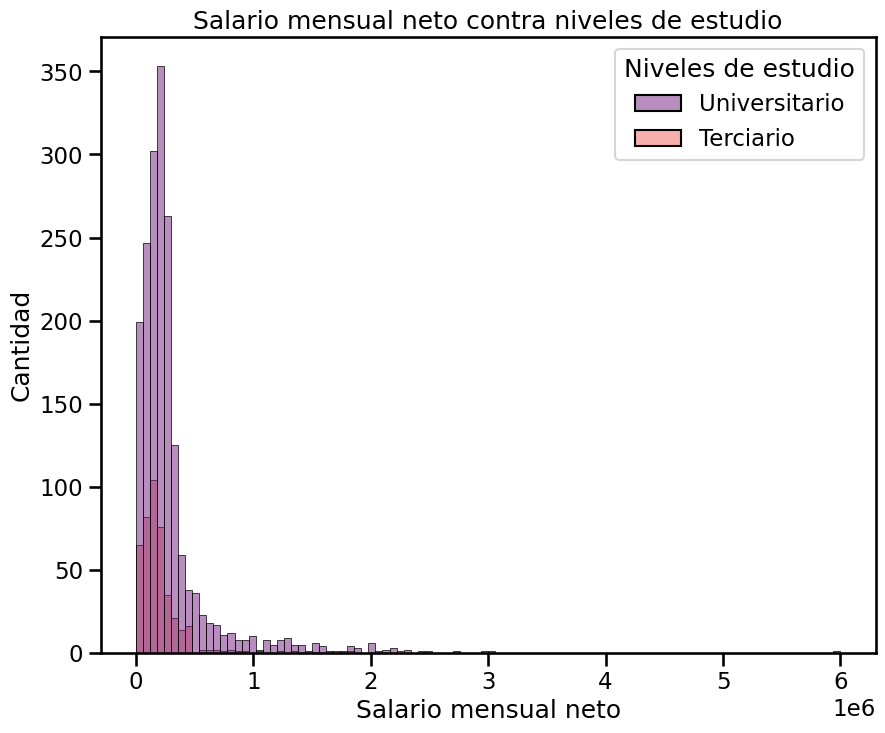

In [15]:
plt.figure(figsize=(10, 8))
ax=sns.histplot(data=df_Uni_o_Ter, x='salary_monthly_NETO',bins=100, hue='profile_studies_level',palette='magma', legend=True) 
ax.set(xlabel='Salario mensual neto', ylabel='Cantidad')
ax.set_title('Salario mensual neto contra niveles de estudio') 
ax.get_legend().set_title('Niveles de estudio')

## d) Densidad Conjunta condicional

Elija dos variables numéricas y una categórica. 
Estudie la dispersión (scatterplot) de las dos variables discriminando en color por la variable categórica (ayuda: hue en seaborn)
